## A/B Testing

A/B Testing is an experiment with two groups to establish which group is superior over the other group.

Typically, A/B testing consists of treatment group and control group.

A/B testing is mostly used in web design, marketing and e-commerce.

Prior to A/B testing, a metric measure needs to be defined upfront to avoid bias.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st

In [2]:
data = pd.read_csv('Fraud_check.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [3]:
sub_data = pd.get_dummies(data).drop_duplicates().drop(['Urban_NO','Undergrad_NO'],axis=1)
sub_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 0 to 599
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Taxable.Income           600 non-null    int64
 1   City.Population          600 non-null    int64
 2   Work.Experience          600 non-null    int64
 3   Undergrad_YES            600 non-null    uint8
 4   Marital.Status_Divorced  600 non-null    uint8
 5   Marital.Status_Married   600 non-null    uint8
 6   Marital.Status_Single    600 non-null    uint8
 7   Urban_YES                600 non-null    uint8
dtypes: int64(3), uint8(5)
memory usage: 21.7 KB


Two important checks required before AB testing:
1. Guardrail Metric Check
2. Power test

#### Guardrail Metric Check

First check prior to A/B testing is to check for significant difference in proportions between two groups using binomial confidence interval as follows:

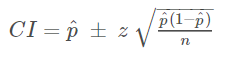

For this example, 0 value indicates control group and 1 value indicates treatment group for "Undergrad_YES" variable

In [4]:
prop = sub_data['Undergrad_YES'].value_counts()/len(sub_data)
prop

1    0.52
0    0.48
Name: Undergrad_YES, dtype: float64

In [5]:
#Guardrail Check on differences in proportions between two groups:
sd = np.sqrt((0.5*(1-0.5))/len(sub_data))
CI = np.round((0.5 - sd*st.norm.ppf(1-0.05/2), 0.5 + sd*st.norm.ppf(1-0.05/2)),4)
print('Does the control group proportion ' + str(round(prop[0],4)) + ' lie within ' + str(CI) + '?')
if prop[0]>CI[0] and prop[0]<CI[1]:
    print('Yes')
else:
    print('No')

Does the control group proportion 0.48 lie within [0.46 0.54]?
Yes


From the example above, the guardrail metric is passed such that the number of unique samples is equal for every undergraduate/non-undergraduate group.

#### Power Test

Another check required prior to AB testing is to determine minimum sample size required based on power test.

Power is the probability of detecting specified effect size with specified sample characteristics (size and variability). In simple terms, power represents probability of correctly rejecting null hypothesis when alternative hypothesis is actually valid.

There are two methods available in Power Test for A/B testing:

1. Statistical rule of thumb

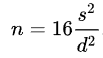

2. Evan Miller's calculator

In [6]:
# Probability of Urban given sample is not an undergrad (Control group)
sub_data[sub_data['Undergrad_YES']==0].Urban_YES.mean()

0.5034722222222222

In [7]:
# Probability of Urban given sample is an undergrad (Treatment group)
sub_data[sub_data['Undergrad_YES']==1].Urban_YES.mean()

0.5032051282051282

In [8]:
# Minimum total sample size required to improve current probability of urban (50.3472%) by 3.5%
16*(0.503472*(1-0.503472))/pow(0.035,2) * 2

6530.297344417959

In [9]:
# Evan Miller's calculator

# Calculating the minimum sample size for the ab test:
def get_sampSize(sds,alpha,beta,d):
    n=pow((st.norm.ppf(1-alpha/2)*sds[0]+st.norm.ppf(1-beta)*sds[1]),2)/pow(d,2)
    return n

#baseline + expected change standard deviation calculations
def get_sds(p,d):
    sd1=np.sqrt(2*p*(1-p))
    sd2=np.sqrt(p*(1-p)+(p+d)*(1-(p+d)))
    sds=[sd1,sd2]
    return sds

In [10]:
# Minimum total sample size required to improve current probability of urban (50.3472%) by 3.5%
get_sampSize(get_sds(0.503472, 0.035),0.05,0.2,0.035)*2

6401.285552817009

In [11]:
# Increasing sample size from 600 to 6531 using bootstrapping method
from sklearn.utils import resample
sub_dataset = resample(sub_data[['Undergrad_YES','Urban_YES']], n_samples=6531)
sub_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6531 entries, 6 to 35
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Undergrad_YES  6531 non-null   uint8
 1   Urban_YES      6531 non-null   uint8
dtypes: uint8(2)
memory usage: 63.8 KB


Note that alpha represents significance level, while beta represents power.

There are 5 different methods for testing difference of probability of urban between undergraduates and non-undergraduates:

1. Binomial Proportion Confidence Interval
2. Z test
3. Hypothesis testing on difference in proportions and effect size
4. Sign test
5. Chi square test

In [12]:
# Binomial Proportion Confidence Interval
N_Undergrad = len(sub_data[sub_data['Undergrad_YES']==0])
N_NonUndergrad = len(sub_data[sub_data['Undergrad_YES']==1])
P_Undergrad = sub_data[sub_data['Undergrad_YES']==0].Urban_YES.mean()
P_NonUndergrad = sub_data[sub_data['Undergrad_YES']==1].Urban_YES.mean()

CI_Undergrad = (P_Undergrad - st.norm.ppf(1-0.025/2)*np.sqrt(P_Undergrad*(1-P_Undergrad)/N_Undergrad),P_Undergrad + st.norm.ppf(1-0.025/2)*np.sqrt(P_Undergrad*(1-P_Undergrad)/N_Undergrad))
CI_NonUndergrad = (P_NonUndergrad - st.norm.ppf(1-0.025/2)*np.sqrt(P_NonUndergrad*(1-P_NonUndergrad)/N_NonUndergrad),P_NonUndergrad + st.norm.ppf(1-0.025/2)*np.sqrt(P_NonUndergrad*(1-P_NonUndergrad)/N_NonUndergrad))
print("95% C.I for Probability of Urban for Undergraduates: ",np.round(CI_Undergrad,4))
print("95% C.I for Probability of Urban for Non-Undergraduates: ",np.round(CI_NonUndergrad,4))

95% C.I for Probability of Urban for Undergraduates:  [0.4374 0.5695]
95% C.I for Probability of Urban for Non-Undergraduates:  [0.4398 0.5667]
